# LeNet-1 PyTorch Implementation

In this notebook, we implement Yann LeCun's LeNet-1 convolutional neural network with PyTorch. We will further train and test the developed model with the MNIST digit classification dataset. LeNet-1 was a small CNN, which merely included five layers. The network was developed to accommodate minute, single-channel images of size (28×28). It boasted a total of 3,246 trainable parameters and 139,402 connections. We import all the libraries below.

In [32]:
import torch
import torchvision
import tqdm

import matplotlib.pyplot as plt
import numpy as np

## Model Implementation in PyTorch

Recall that the LeNet-1 model contains only five layers, and they are:

1. Layer C1: Convolution Layer (4, 5×5)
2. Layer S2: Pooling Layer (2×2)
3. Layer C3: Convolution Layer (12, 5×5)
4. Layer S4: Pooling Layer (2×2)
5. Layer F5: Fully Connected Layer (10)

This can be implemented in PyTorch as shown below.


In [33]:
class LeNet1(torch.nn.Module):
    """
    The LeNet-1 module.
    """

    def __init__(self):

        # Mandatory call to super class module.
        super(LeNet1, self).__init__()

        # Defining the feature extraction layers.
        self.feature_extractor = torch.nn.Sequential(

            # Layer 1 - Conv2d(4, 5x5) - Nx1x28x28 -> Nx4x24x24
            torch.nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5),
            torch.nn.Tanh(),

            # Layer 2 - AvgPool2d(2x2) - Nx4x24x24 -> Nx4x12x12
            torch.nn.AvgPool2d(kernel_size=2, stride=2),

            # Layer 3 - Conv2d(12, 5x5) - Nx4x12x12 -> Nx12x8x8
            torch.nn.Conv2d(in_channels=4, out_channels=12, kernel_size=5),
            torch.nn.Tanh(),

            # Layer 4 - AvgPool2d(2x2) - Nx12x8x8 -> Nx12x4x4
            torch.nn.AvgPool2d(kernel_size=2, stride=2),
        )

        # Defining the classification layers.
        self.classifier = torch.nn.Sequential(

            # Layer 5 - FullyConnected(10) - Nx1x192 -> Nx1x10
            torch.nn.Linear(in_features=12*4*4, out_features=10),
            torch.nn.Softmax()
        )

    def forward(self, x):

        # Forward pass through the feature extractor - Nx1x28x28 -> Nx12x4x4
        x = self.feature_extractor(x)

        # Flattening the feature map - Nx12x4x4 -> Nx1x192
        x = torch.flatten(x, 1)

        # Forward pass through the classifier - Nx1x192 -> Nx1x10
        return self.classifier(x)


## Loading the MNIST dataset

Next we load the MNIST digit classification dataset. Luckily, PyTorch has a nifty solution that allows up to easily download the dataset and use it. This solution is shown below.


In [34]:
# Defining a transform for the images.
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0,), (1,))]
)

# Loading the training and validation data.
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)
#val_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)

# Loading the testing data.
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=False, num_workers=2)
val_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=False, num_workers=2)

# Defining the classes [0, ..., 9].
classes = [x for x in range(10)]

### Showing Sample Images

To confirm that the data was loaded correctly, we design a function below to show some sample images from the dataset.

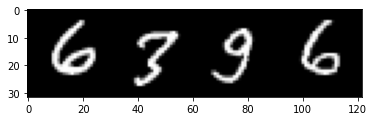

    6     3     9     6


In [35]:
def show_image(image):
    npimg = image.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_sample_images():

    # get some random training images
    dataiter = iter(train_loader)
    images, labels = dataiter.next()

    # Showing the image(s).
    show_image(torchvision.utils.make_grid(images))

    # Printing the labels.
    print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

show_sample_images()

## Using the model

Before we proceed, we check to see your the machine has a GPU installed. If so, we use the GPU for training, else, we use the CPU.

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [37]:
model = LeNet1().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Training the model

We devise a function below to train the model. We use regular Stochastic Gradient Descent and Mean Squared Error loss for training as defined by LeCun.

In [38]:
def train(model, train_loader, val_loader, optimizer, epochs):

    # Iterate for several epochs
    for epoch in tqdm.tqdm(range(epochs)):
        train_loss = val_loss = 0.0

        for phase in ['train', 'val']:
            
            if phase == 'train':
                loader = train_loader
            else:
                loader = val_loader

            # Iterate for each data item in the training set
            for i, data in enumerate(loader, 0):
                
                # Get the sample input data.
                inputs, labels = data[0].to(device), data[1].to(device)

                # Reset the gradients
                optimizer.zero_grad()

                # Perform forward pass.
                outputs = model(inputs)

                print(outputs, labels)

                # Calculate current model loss.
                loss = criterion(outputs, labels)

                if phase == 'train':
                     
                     # Perform backward pass.
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item()
                else:
                    val_loss += loss.item()
        
        print('Epoch %d - Train Loss: %.3f Validation Loss %.3f' % (epoch + 1, train_loss/len(train_loader), val_loss/len(val_loader)))

    print('Finished Training')

train(model, train_loader, val_loader, optimizer, 6)

  0%|          | 0/6 [00:01<?, ?it/s]tensor([[0.0982, 0.0951, 0.0879, 0.0908, 0.1142, 0.1077, 0.0765, 0.0963, 0.1208,
         0.1124],
        [0.1075, 0.0921, 0.0842, 0.0948, 0.1117, 0.1154, 0.0723, 0.0945, 0.1144,
         0.1131],
        [0.1008, 0.0916, 0.0843, 0.0852, 0.1120, 0.1093, 0.0776, 0.0939, 0.1211,
         0.1241],
        [0.1045, 0.0923, 0.0871, 0.0914, 0.1080, 0.1100, 0.0796, 0.0914, 0.1172,
         0.1184]], grad_fn=<SoftmaxBackward>) tensor([1, 8, 3, 5])



RuntimeError: The size of tensor a (10) must match the size of tensor b (4) at non-singleton dimension 1

## Evaluating the Model

We evaluate the model on a ransom sample of test data to see how well it performs.

In [ ]:
def test(model, test_loader):

    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # Showing the test images
    show_image(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

    outputs = model(images.to(device))
    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

test(model, test_loader)

### Evaluating on the entire dataset

We further evaluate the model's performance on the entire dataset.

In [ ]:
def test_full(model, test_loader):

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

test_full(model, test_loader)

### Evaluating class by class

We further evaluate the class by class accuracy of the model

In [ ]:
def test_class(model, test_loader):

    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images.to(device))
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

test_class(model, test_loader)